In [ ]:
# !pip install arch

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

# import statsmodels.graphics.tsaplots as sgt # ACF and PACF
# import statsmodels.tsa.stattools as sts  # for dickey fuller test
# from arch import arch_model
# import scipy.stats as scs
import numpy as np

# from scipy.stats.distributions import chi2 # for LLR test

# import scipy.stats
# import pylab # for qq plot
# from statsmodels.stats.diagnostic import het_arch

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [ ]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

# Loading clean data

In [ ]:
# importing clean data
data=pd.read_feather('/content/clean_data_cols_price_lr_slr_sslr_rv_srv.feather')

In [ ]:
data.head()

,Price,log_return,scaled_log_return,realised_volatility_of_5,scaled_realised_volatility_of_5,squared_log_return
Date,,,,,,
2001-01-01,65.41,0.000000,-0.019382,0.032416,0.379606,0.000376
2001-01-02,65.41,0.000000,-0.019382,0.031055,0.363380,0.000376
2001-01-03,65.38,-0.000459,-0.053517,0.030148,0.352559,0.002864
2001-01-04,70.14,0.070277,5.209798,0.045589,0.536702,27.141995
2001-01-05,73.15,0.042019,3.107171,0.033568,0.393350,9.654515


# Preparing data

## Setting value for using past data

In [ ]:
past_data_size=23

## Function to convert data in **window** format

In [ ]:
def convert_in_windows(scaled_log_returns, scaled_realised_volatility, window_size=23):
  windowed_scaled_log_returns=np.array([])

  for i in range(window_size,len(scaled_log_returns)+1):
    for_appending = scaled_log_returns.iloc[i-window_size:i].values.reshape(1,-1)
    if windowed_scaled_log_returns.shape[0] == 0:
      windowed_scaled_log_returns = for_appending
    else:
      windowed_scaled_log_returns = np.append(windowed_scaled_log_returns,for_appending,axis=0)

  target_scaled_realised_volatility = scaled_realised_volatility.iloc[window_size:].values.reshape(-1,1)

  return windowed_scaled_log_returns, target_scaled_realised_volatility

## Extracting main columns

In [ ]:
main_data=data[['scaled_log_return','scaled_realised_volatility_of_5']]

## Convert whole data in windows

In [ ]:
windowed_data,Y=convert_in_windows(main_data['scaled_log_return'],main_data['scaled_realised_volatility_of_5'])

In [ ]:
windowed_data.shape,Y.shape

((6288, 23), (6287, 1))

# Import params of EGARCH for **whole data**

In [ ]:
params_EGARCH_ged=pd.read_feather('/content/params_EGARCH_ged.feather')
params_EGARCH_t=pd.read_feather('/content/params_EGARCH_t.feather')
params_EGARCH_skewt=pd.read_feather('/content/params_EGARCH_skewt.feather')
params_EGARCH_norm=pd.read_feather('/content/params_EGARCH_norm.feather')

# Appending EGARCH parameters at the end of windowed data

## **EGARCH** params appended to Windowed **whole data**

In [ ]:
windowed_data_EGARCH_ged_params =np.append(windowed_data,params_EGARCH_ged,axis=1)
windowed_data_EGARCH_t_params =np.append(windowed_data,params_EGARCH_t,axis=1)
windowed_data_EGARCH_skewt_params =np.append(windowed_data,params_EGARCH_skewt,axis=1)
windowed_data_EGARCH_norm_params =np.append(windowed_data,params_EGARCH_norm,axis=1)

# all distributions combined
windowed_data_EGARCH_all_dist=np.append(windowed_data,params_EGARCH_ged,axis=1)
windowed_data_EGARCH_all_dist=np.append(windowed_data_EGARCH_all_dist,params_EGARCH_t,axis=1)
windowed_data_EGARCH_all_dist=np.append(windowed_data_EGARCH_all_dist,params_EGARCH_skewt,axis=1)
windowed_data_EGARCH_all_dist=np.append(windowed_data_EGARCH_all_dist,params_EGARCH_norm,axis=1)

# Defining Model Architecture

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

def get_model(X_train):

  # shape=(X_train.shape[1],1)
  input_layer = Input(shape=(X_train.shape[1],1))
  model=Sequential()
  model.add(input_layer)
  model.add(LSTM(units=64,return_sequences=True))
  model.add(Dropout(rate=0.3))
  model.add(LSTM(units=32,return_sequences=True))
  model.add(Dropout(rate=0.8))
  model.add(LSTM(units=16,return_sequences=False))
  model.add(Dropout(rate=0.8))
  model.add(Dense(units=10))
  model.add(Dense(units=1))
  model.compile(optimizer=Adam(learning_rate=0.0001),loss='MeanSquaredError')

  return model

In [ ]:
from tensorflow import keras

# Callback Functions

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True,min_delta=0.0005)

In [ ]:
windowed_data.shape,params_EGARCH_ged.shape, windowed_data_EGARCH_ged_params.shape

((6288, 23), (6288, 3), (6288, 26))

# Function for saving predictions and actuals

In [ ]:
def save_preds_actuals(tup:tuple, model_name:str, dist_name:str):

  if model_name!='GARCH' and model_name!='EGARCH':
    print('Model name should be either GARCH or EGARCH')
    return

  if dist_name not in['ged','t','skewt','norm','all_dist']:
    print('Distribution name should be either ged, t, skewt or norm')
    return

  # print()
  train_preds_actuals_df=pd.DataFrame({'train preds':np.array(tup[0]).reshape(-1),
                                       'train trues':np.array(tup[1]).reshape(-1)})

  test_preds_actuals_df=pd.DataFrame({'test preds':np.array(tup[2]).reshape(-1),
                                       'test trues':np.array(tup[3]).reshape(-1)})

  train_preds_actuals_df.to_feather(f'{model_name}_with_{dist_name}_walk_forward_train_preds_and_actuals.feather')
  test_preds_actuals_df.to_feather(f'{model_name}_with_{dist_name}_walk_forward_test_preds_and_actuals.feather')

  print('data saved!')

# Walk Forward Validation

In [ ]:
def walk_forward_validation(windowed_data_with_params,
                            Y,
                            train_fold_size=2387,
                            test_fold_size=1300):
  train_MSEs=[]
  train_MAEs=[]
  train_RMSEs=[]

  all_train_preds=[]
  all_train_trues=[]

  test_MSEs=[]
  test_MAEs=[]
  test_RMSEs=[]

  all_test_preds=[]
  all_test_trues=[]

  X=np.expand_dims(windowed_data_with_params,axis=2)[:-1]  # here we are not taking last column because for last column there won't be any predictions because predictions are in new columns

  X_len=len(X)
  # print(X_len)

  for start in range(0,
                     (X_len - train_fold_size - test_fold_size) + 1,  # + 1 because we want loop to run whien start = 2600
                     test_fold_size):
  # print(len(x_train),len(x_val))
  #   print(x_val[-1])
    print(f'train-> {start} : {start + train_fold_size}, test-> {start + train_fold_size} : {start + train_fold_size + test_fold_size}' )

  for start in range(0,
                     (X_len - train_fold_size - test_fold_size) + 1,
                     test_fold_size):
    X_train, X_test = X[start : (start + train_fold_size)], X[(start + train_fold_size) : (start + train_fold_size + test_fold_size)]
    Y_train, Y_test = Y[start : (start + train_fold_size)], Y[(start + train_fold_size) : (start + train_fold_size + test_fold_size)]


    val_data_size=int(X_train.shape[0]*0.2)
    x_train,x_val=X_train[:-val_data_size],X_train[-val_data_size:]
    y_train,y_val=Y_train[:-val_data_size],Y_train[-val_data_size:]

    model=get_model(x_train)
    model_fit=model.fit(x_train,
                        y_train,
                        validation_data=(x_val,y_val),
                        batch_size=20,
                        epochs=150,
                        callbacks=[early_stopping],
                        verbose=False)



    # for train data
    train_preds=model.predict(X_train)
    # train_trues=(Y_train)

    all_train_preds.extend(train_preds)
    all_train_trues.extend(Y_train)

    curr_train_MSE=mean_squared_error(Y_train,train_preds)
    curr_train_MAE=mean_absolute_error(Y_train,train_preds)
    curr_train_RMSE=root_mean_squared_error(Y_train,train_preds)

    train_MSEs.append(curr_train_MSE)
    train_MAEs.append(curr_train_MAE)
    train_RMSEs.append(curr_train_RMSE)

    # For test data
    test_preds=model.predict(X_test)
    # test_trues=(y_test)

    all_test_preds.extend(test_preds) # prediction for 1300 points
    all_test_trues.extend(Y_test)

    curr_test_MSE=mean_squared_error(Y_test,test_preds)
    curr_test_MAE=mean_absolute_error(Y_test,test_preds)
    curr_test_RMSE=root_mean_squared_error(Y_test,test_preds)

    test_MSEs.append(curr_test_MSE)
    test_MAEs.append(curr_test_MAE)
    test_RMSEs.append(curr_test_RMSE)




  return {'train_MSE':train_MSEs,'train_MAE':train_MAEs,'train_RMSE':train_RMSEs,'test_MSE':test_MSEs, 'test_MAE':test_MAEs, 'test_RMSE':test_RMSEs}, (all_train_preds, all_train_trues, all_test_preds, all_test_trues)



# Model : (EGARCH + GED) + LSTM

In [ ]:
EGARCH_ged_metric, EGARCH_ged_preds_actuals=walk_forward_validation(windowed_data_EGARCH_ged_params,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
12/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/array_slicing.py:63: RuntimeWarning: overflow encountered in cast
  return x.astype(dtype)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


## saving train, test preds and actuals

In [ ]:
save_preds_actuals(tup=EGARCH_ged_preds_actuals,
                   model_name='EGARCH',
                   dist_name='ged')

data saved!


In [ ]:
print('Train:')
print(EGARCH_ged_metric['train_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_ged_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test:')
print(EGARCH_ged_metric['test_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_ged_metric['test_MSE']).mean())

Train:
[0.007623673123871917, 0.008771460546922022, 0.003465973833512035]
Mean of MSEs :  0.006620369168101992
------------------------------------------------------------------
Test:
[0.004157163575665666, 0.001959277929010667, 0.0082781922138563]
Mean of MSEs :  0.004798211239510877


In [ ]:
print('Train')
print(EGARCH_ged_metric['train_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_ged_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_ged_metric['test_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_ged_metric['test_MAE']).mean())

Train
[0.06161334284566094, 0.057861807139325386, 0.03915578359061499]
Mean of MAEs :  0.05287697785853377
------------------------------------------------------------------
Test
[0.05350497898452721, 0.03549155743063058, 0.05896341754755534]
Mean of MAEs :  0.0493199846542377


In [ ]:
print('Train')
print(EGARCH_ged_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_ged_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_ged_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_ged_metric['test_RMSE']).mean())

Train
[0.08731364798169824, 0.09365607586762335, 0.05887252188850105]
Mean of RMSEs :  0.07994741524594089
------------------------------------------------------------------
Test
[0.06447606979078103, 0.04426373153057328, 0.09098457129566694]
Mean of RMSEs :  0.06657479087234042


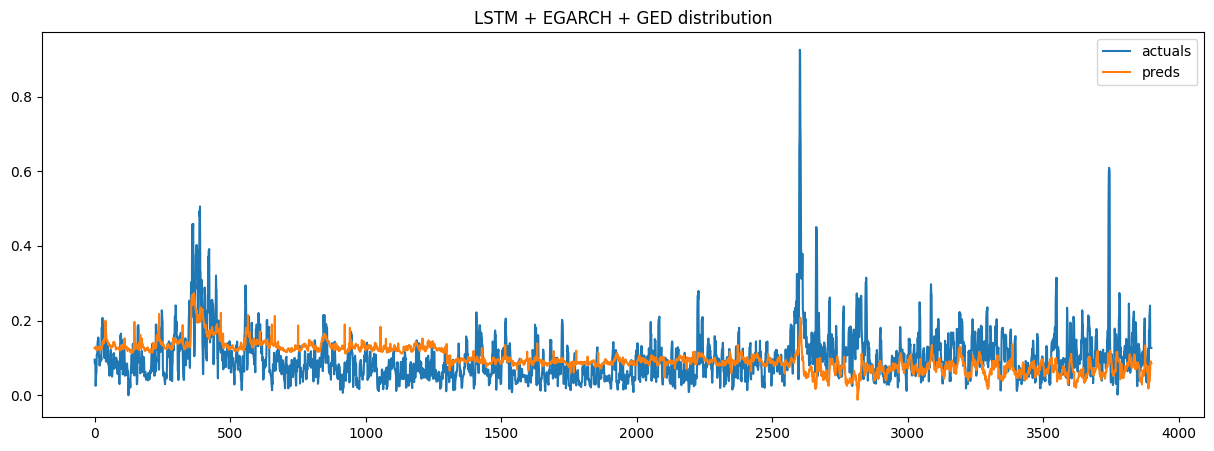

In [ ]:
all_test_preds=EGARCH_ged_preds_actuals[2]
all_test_actuals=EGARCH_ged_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + EGARCH + GED distribution')
plt.show()

# Model : (EGARCH + t) + LSTM

In [ ]:
EGARCH_t_metric, EGARCH_t_preds_actuals=walk_forward_validation(windowed_data_EGARCH_t_params,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


## saving train, test preds and actuals

In [ ]:
save_preds_actuals(tup=EGARCH_t_preds_actuals,
                   model_name='EGARCH',
                   dist_name='t')

data saved!


In [ ]:
print('Train')
print(EGARCH_t_metric['train_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_t_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_t_metric['test_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_t_metric['test_MSE']).mean())

Train
[0.007666267859307723, 0.008565834104220686, 0.0038783804735004154]
Mean of MSEs :  0.006703494145676275
------------------------------------------------------------------
Test
[0.0045050840798086765, 0.0020499357300296102, 0.008178514742463946]
Mean of MSEs :  0.004911178184100745


In [ ]:
print('Train')
print(EGARCH_t_metric['train_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_t_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_t_metric['test_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_t_metric['test_MAE']).mean())

Train
[0.06232637659757197, 0.057742131239730675, 0.04241374031769831]
Mean of MAEs :  0.05416074938500032
------------------------------------------------------------------
Test
[0.056646134127898706, 0.03631298234055341, 0.05603384701972561]
Mean of MAEs :  0.049664321162725907


In [ ]:
print('Train')
print(EGARCH_t_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_t_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_t_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_t_metric['test_RMSE']).mean())

Train
[0.08755722619697202, 0.09255179146953713, 0.06227664468723741]
Mean of RMSEs :  0.08079522078458219
------------------------------------------------------------------
Test
[0.06711992312129593, 0.04527621594203308, 0.09043514108168321]
Mean of RMSEs :  0.06761042671500407


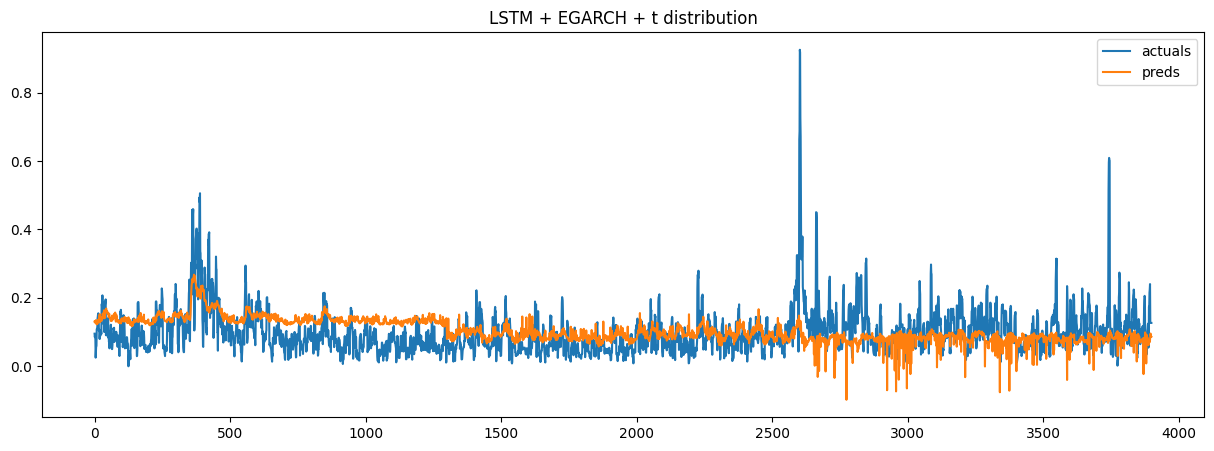

In [ ]:
all_test_preds=EGARCH_t_preds_actuals[2]
all_test_actuals=EGARCH_t_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + EGARCH + t distribution')
plt.show()

# Model : (EGARCH + skewt) + LSTM

In [ ]:
EGARCH_skewt_metric, EGARCH_skewt_preds_actuals=walk_forward_validation(windowed_data_EGARCH_skewt_params,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


## saving train, test preds and actuals

In [ ]:
save_preds_actuals(tup=EGARCH_skewt_preds_actuals,
                   model_name='EGARCH',
                   dist_name='skewt')

data saved!


In [ ]:
print('Train')
print(EGARCH_skewt_metric['train_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_skewt_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_skewt_metric['test_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_skewt_metric['test_MSE']).mean())

Train
[0.007582406538807008, 0.008228329964328021, 0.0023807483636271542]
Mean of MSEs :  0.006063828288920728
------------------------------------------------------------------
Test
[0.004135271283352354, 0.002871888877056416, 0.005781374411112306]
Mean of MSEs :  0.004262844857173692


In [ ]:
print('Train')
print(EGARCH_skewt_metric['train_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_skewt_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_skewt_metric['test_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_skewt_metric['test_MAE']).mean())

Train
[0.061406609701401334, 0.05864382166195564, 0.035926594302042605]
Mean of MAEs :  0.05199234188846652
------------------------------------------------------------------
Test
[0.05348161953828966, 0.0429525634972529, 0.047117976425727216]
Mean of MAEs :  0.04785071982042325


In [ ]:
print('Train')
print(EGARCH_skewt_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_skewt_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_skewt_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_skewt_metric['test_RMSE']).mean())

Train
[0.08707701498562642, 0.09071014256591167, 0.04879291304715424]
Mean of RMSEs :  0.07552669019956411
------------------------------------------------------------------
Test
[0.06430607501124877, 0.05359000725001272, 0.07603534974676125]
Mean of RMSEs :  0.06464381066934093


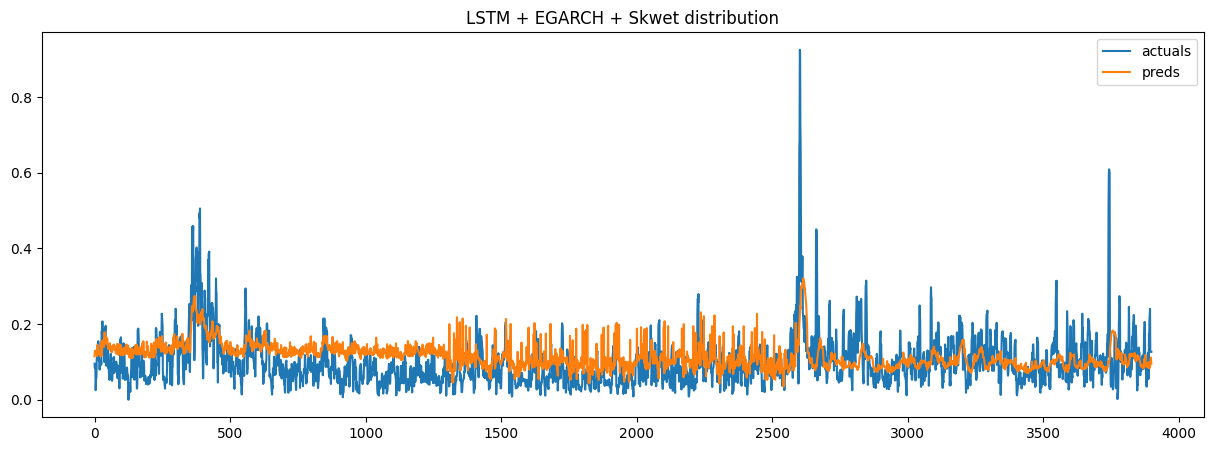

In [ ]:
all_test_preds=EGARCH_skewt_preds_actuals[2]
all_test_actuals=EGARCH_skewt_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + EGARCH + Skwet distribution')
plt.show()

# Model : (EGARCH + normal) + LSTM

In [ ]:
EGARCH_norm_metric, EGARCH_norm_preds_actuals=walk_forward_validation(windowed_data_EGARCH_norm_params,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


## saving train, test preds and actuals

In [ ]:
save_preds_actuals(tup=EGARCH_norm_preds_actuals,
                   model_name='EGARCH',
                   dist_name='norm')

data saved!


In [ ]:
print('Train')
print(EGARCH_norm_metric['train_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_norm_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_norm_metric['test_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_norm_metric['test_MSE']).mean())

Train
[0.0076100330657940226, 0.009112024402325222, 0.002787527445794691]
Mean of MSEs :  0.006503194971304645
------------------------------------------------------------------
Test
[0.0046477997998994125, 0.0019320868250370564, 0.00611929374481007]
Mean of MSEs :  0.004233060123248846


In [ ]:
print('Train')
print(EGARCH_norm_metric['train_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_norm_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_norm_metric['test_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_norm_metric['test_MAE']).mean())

Train
[0.06225553821468882, 0.058866080605354365, 0.03738909336717203]
Mean of MAEs :  0.05283690406240507
------------------------------------------------------------------
Test
[0.05765819216252512, 0.035301237719513615, 0.0473170773531601]
Mean of MAEs :  0.04675883574506628


In [ ]:
print('Train')
print(EGARCH_norm_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_norm_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_norm_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_norm_metric['test_RMSE']).mean())

Train
[0.08723550347074305, 0.09545692432885747, 0.05279704012342634]
Mean of RMSEs :  0.07849648930767562
------------------------------------------------------------------
Test
[0.06817477392628019, 0.043955509609570634, 0.07822591479049683]
Mean of RMSEs :  0.06345206610878255


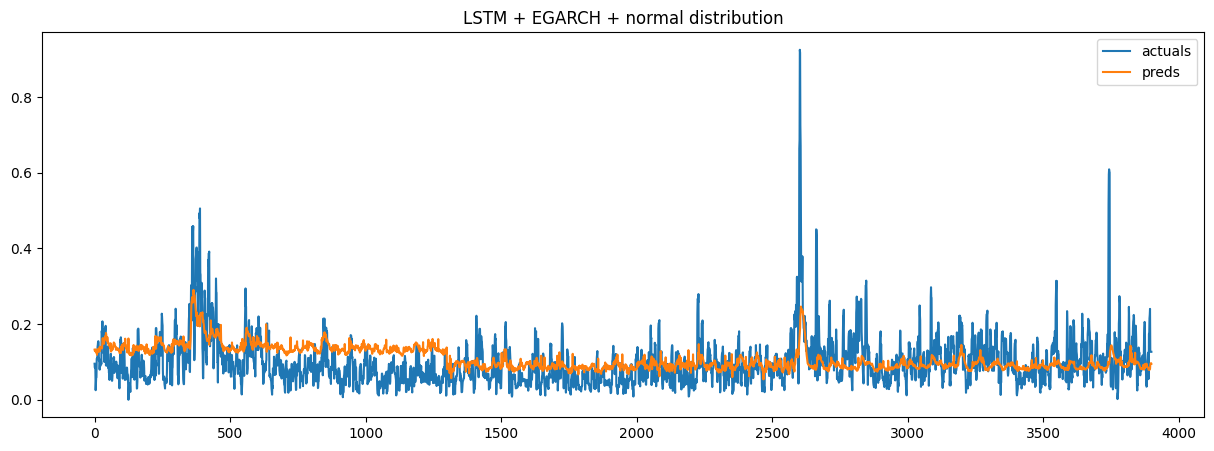

In [ ]:
all_test_preds=EGARCH_norm_preds_actuals[2]
all_test_actuals=EGARCH_norm_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + EGARCH + normal distribution')
plt.show()

# (EGARCH + all_dist) + LSTM

In [ ]:
EGARCH_all_dist_metric, EGARCH_all_dist_preds_actuals=walk_forward_validation(windowed_data_EGARCH_all_dist,Y)

train-> 0 : 2387, test-> 2387 : 3687
train-> 1300 : 3687, test-> 3687 : 4987
train-> 2600 : 4987, test-> 4987 : 6287
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
 9/41 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/array_slicing.py:63: RuntimeWarning: overflow encountered in cast
  return x.astype(dtype)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


## Saving train, test preds and actuals

In [ ]:
save_preds_actuals(tup=EGARCH_all_dist_preds_actuals,
                   model_name='EGARCH',
                   dist_name='all_dist')

data saved!


In [ ]:
print('Train')
print(EGARCH_all_dist_metric['train_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_all_dist_metric['train_MSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_all_dist_metric['test_MSE'])
print('Mean of MSEs : ',np.array(EGARCH_all_dist_metric['test_MSE']).mean())

Train
[0.008294497058772162, 0.009839244614920424, 0.0037171129698354]
Mean of MSEs :  0.007283618214509329
------------------------------------------------------------------
Test
[0.005126575366913836, 0.0029473972192972228, 0.008445762810449757]
Mean of MSEs :  0.005506578465553605


In [ ]:
print('Train')
print(EGARCH_all_dist_metric['train_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_all_dist_metric['train_MAE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_all_dist_metric['test_MAE'])
print('Mean of MAEs : ',np.array(EGARCH_all_dist_metric['test_MAE']).mean())

Train
[0.06440857318896397, 0.06316161249639864, 0.04018113426976243]
Mean of MAEs :  0.05591710665170835
------------------------------------------------------------------
Test
[0.06059083832525306, 0.0439218243448693, 0.057662000079964554]
Mean of MAEs :  0.05405822091669563


In [ ]:
print('Train')
print(EGARCH_all_dist_metric['train_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_all_dist_metric['train_RMSE']).mean())
print('------------------------------------------------------------------')
print('Test')
print(EGARCH_all_dist_metric['test_RMSE'])
print('Mean of RMSEs : ',np.array(EGARCH_all_dist_metric['test_RMSE']).mean())

Train
[0.09107412947029558, 0.09919296655973357, 0.0609681307720304]
Mean of RMSEs :  0.08374507560068652
------------------------------------------------------------------
Test
[0.07160010731077039, 0.0542899366300719, 0.0919008313915046]
Mean of RMSEs :  0.07259695844411564


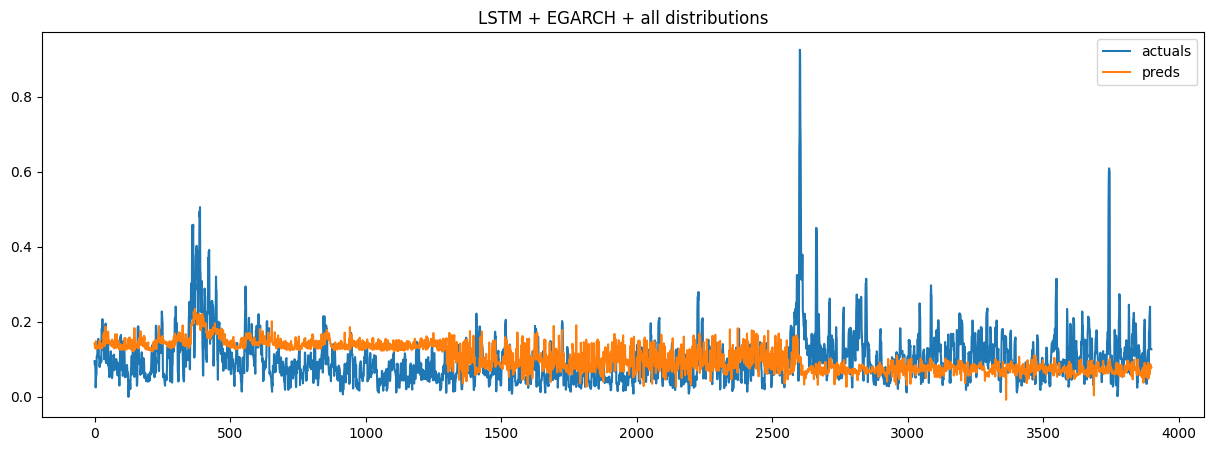

In [ ]:
all_test_preds=EGARCH_all_dist_preds_actuals[2]
all_test_actuals=EGARCH_all_dist_preds_actuals[3]

plt.figure(figsize=(15,5))
plt.plot(all_test_actuals,label='actuals')
plt.plot(all_test_preds,label='preds')
plt.legend()
plt.title('LSTM + EGARCH + all distributions')
plt.show()

# Bar Graphs of metrics

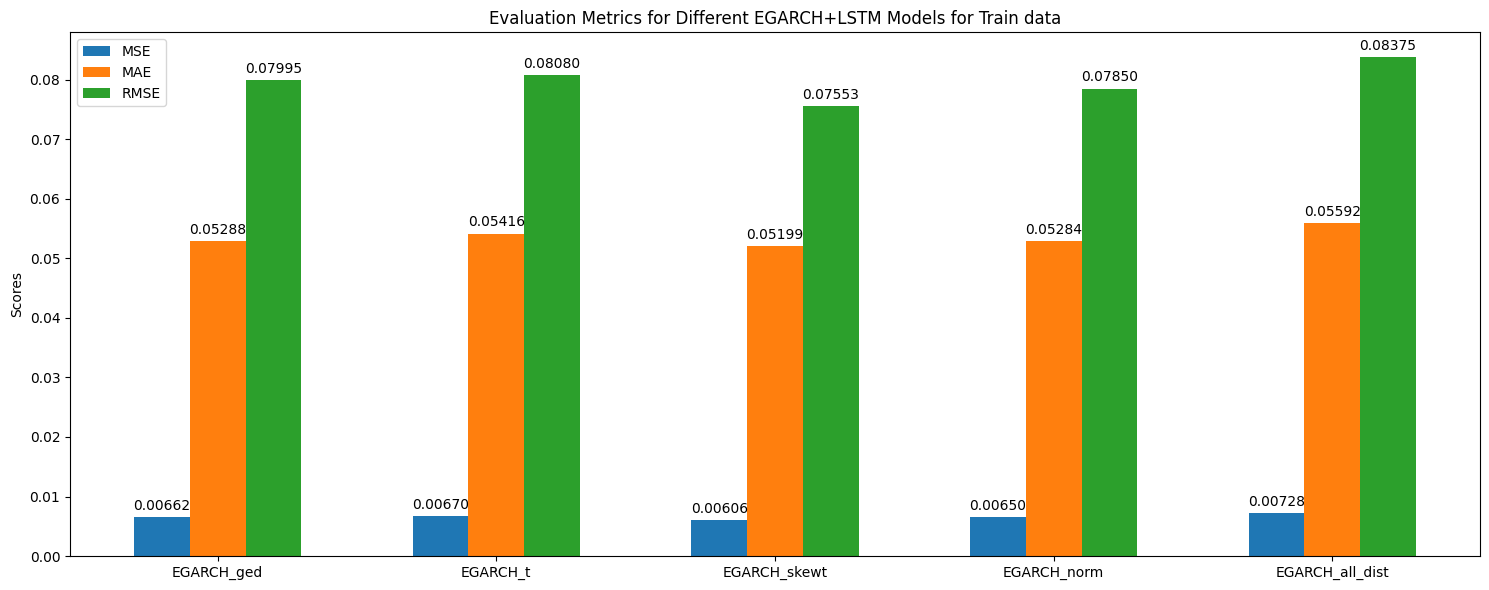

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['EGARCH_ged', 'EGARCH_t', 'EGARCH_skewt', 'EGARCH_norm', 'EGARCH_all_dist']
mse_scores = [
    np.array(EGARCH_ged_metric['train_MSE']).mean(),
    np.array(EGARCH_t_metric['train_MSE']).mean(),
    np.array(EGARCH_skewt_metric['train_MSE']).mean(),
    np.array(EGARCH_norm_metric['train_MSE']).mean(),
    np.array(EGARCH_all_dist_metric['train_MSE']).mean(),
]
mae_scores = [
    np.array(EGARCH_ged_metric['train_MAE']).mean(),
    np.array(EGARCH_t_metric['train_MAE']).mean(),
    np.array(EGARCH_skewt_metric['train_MAE']).mean(),
    np.array(EGARCH_norm_metric['train_MAE']).mean(),
    np.array(EGARCH_all_dist_metric['train_MAE']).mean(),
]
rmse_scores = [
    np.array(EGARCH_ged_metric['train_RMSE']).mean(),
    np.array(EGARCH_t_metric['train_RMSE']).mean(),
    np.array(EGARCH_skewt_metric['train_RMSE']).mean(),
    np.array(EGARCH_norm_metric['train_RMSE']).mean(),
    np.array(EGARCH_all_dist_metric['train_RMSE']).mean(),
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, mse_scores, width, label='MSE')
rects2 = ax.bar(x, mae_scores, width, label='MAE')
rects3 = ax.bar(x + width, rmse_scores, width, label='RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Different EGARCH+LSTM Models for Train data')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("Evaluation Metrics for Different EGARCH+LSTM Models for Train data.jpg")
plt.show()


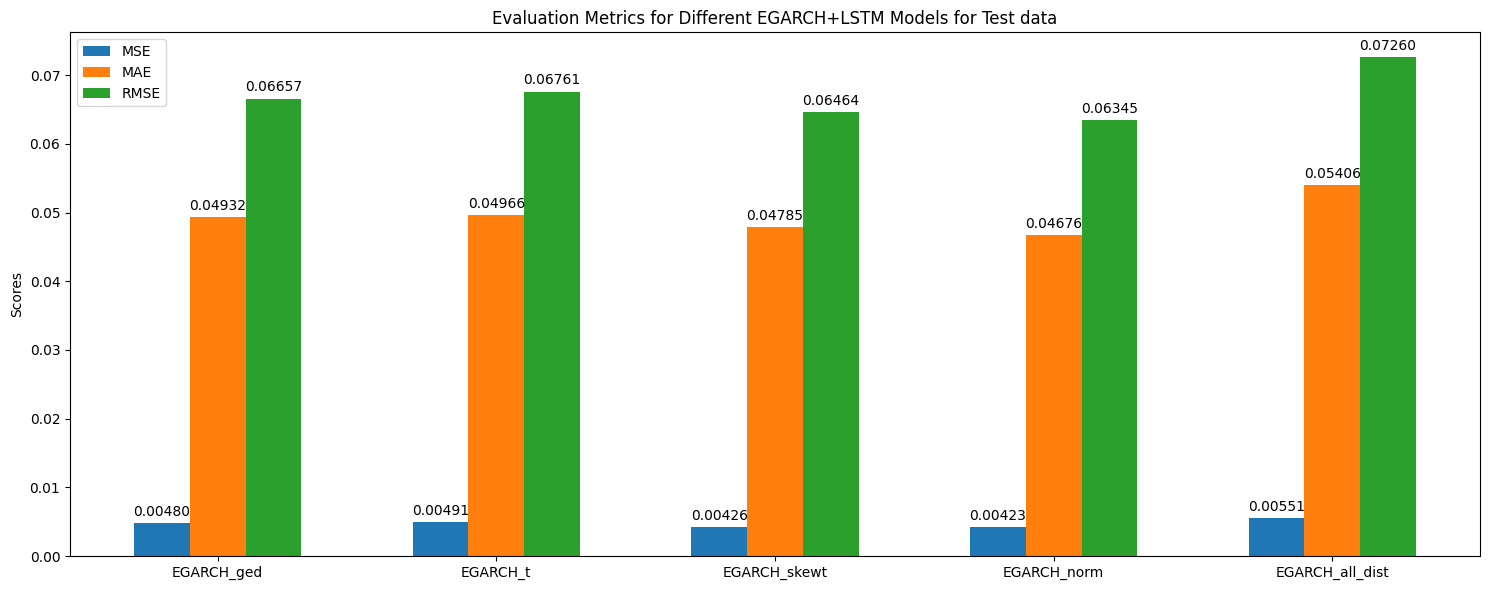

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['EGARCH_ged', 'EGARCH_t', 'EGARCH_skewt', 'EGARCH_norm', 'EGARCH_all_dist']
mse_scores = [
    np.array(EGARCH_ged_metric['test_MSE']).mean(),
    np.array(EGARCH_t_metric['test_MSE']).mean(),
    np.array(EGARCH_skewt_metric['test_MSE']).mean(),
    np.array(EGARCH_norm_metric['test_MSE']).mean(),
    np.array(EGARCH_all_dist_metric['test_MSE']).mean(),
]
mae_scores = [
    np.array(EGARCH_ged_metric['test_MAE']).mean(),
    np.array(EGARCH_t_metric['test_MAE']).mean(),
    np.array(EGARCH_skewt_metric['test_MAE']).mean(),
    np.array(EGARCH_norm_metric['test_MAE']).mean(),
    np.array(EGARCH_all_dist_metric['test_MAE']).mean(),
]
rmse_scores = [
    np.array(EGARCH_ged_metric['test_RMSE']).mean(),
    np.array(EGARCH_t_metric['test_RMSE']).mean(),
    np.array(EGARCH_skewt_metric['test_RMSE']).mean(),
    np.array(EGARCH_norm_metric['test_RMSE']).mean(),
    np.array(EGARCH_all_dist_metric['test_RMSE']).mean(),
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, mse_scores, width, label='MSE')
rects2 = ax.bar(x, mae_scores, width, label='MAE')
rects3 = ax.bar(x + width, rmse_scores, width, label='RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Different EGARCH+LSTM Models for Test data')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("Evaluation Metrics for Different EGARCH+LSTM Models for Test data.jpg")
plt.show()


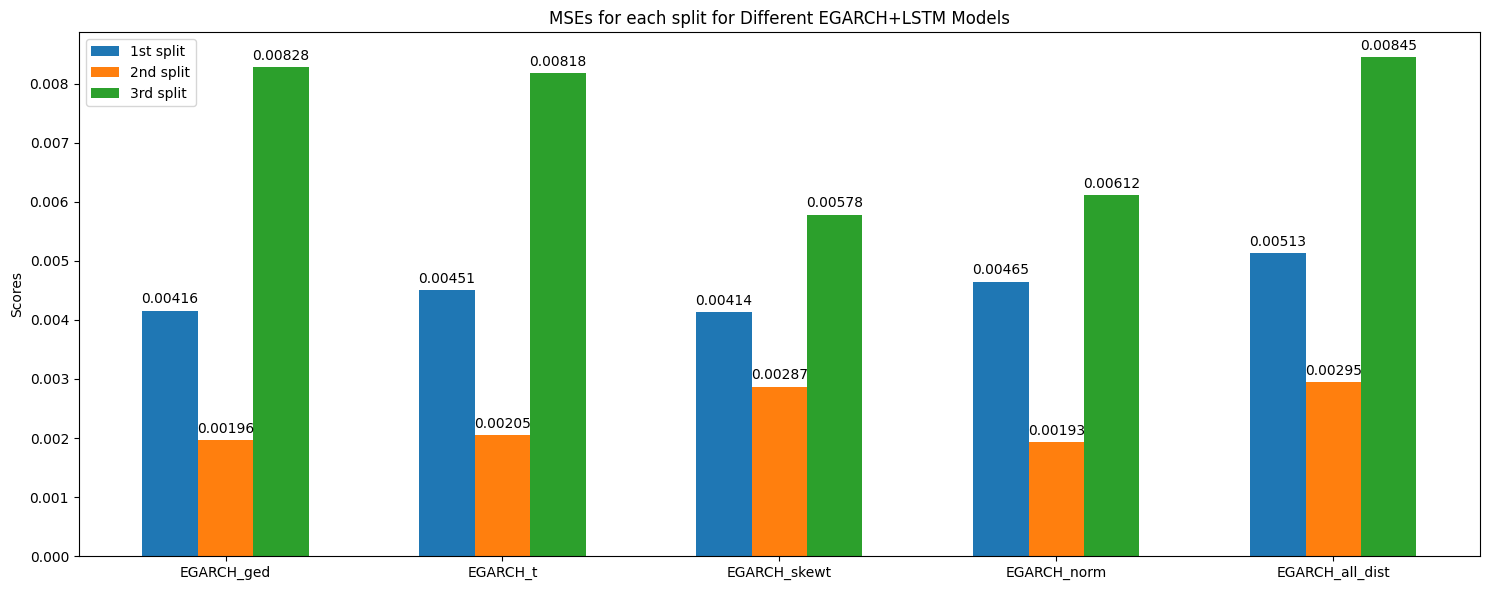

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['EGARCH_ged', 'EGARCH_t', 'EGARCH_skewt', 'EGARCH_norm', 'EGARCH_all_dist']
mse_scores = [
    np.array(EGARCH_ged_metric['test_MSE'])[0],
    np.array(EGARCH_t_metric['test_MSE'])[0],
    np.array(EGARCH_skewt_metric['test_MSE'])[0],
    np.array(EGARCH_norm_metric['test_MSE'])[0],
    np.array(EGARCH_all_dist_metric['test_MSE'])[0],
]
mae_scores = [
    np.array(EGARCH_ged_metric['test_MSE'])[1],
    np.array(EGARCH_t_metric['test_MSE'])[1],
    np.array(EGARCH_skewt_metric['test_MSE'])[1],
    np.array(EGARCH_norm_metric['test_MSE'])[1],
    np.array(EGARCH_all_dist_metric['test_MSE'])[1],
]
rmse_scores = [
    np.array(EGARCH_ged_metric['test_MSE'])[2],
    np.array(EGARCH_t_metric['test_MSE'])[2],
    np.array(EGARCH_skewt_metric['test_MSE'])[2],
    np.array(EGARCH_norm_metric['test_MSE'])[2],
    np.array(EGARCH_all_dist_metric['test_MSE'])[2],
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, mse_scores, width, label='1st split')
rects2 = ax.bar(x, mae_scores, width, label='2nd split')
rects3 = ax.bar(x + width, rmse_scores, width, label='3rd split')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MSEs for each split for Different EGARCH+LSTM Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("MSEs for each split for Different EGARCH+LSTM Models.jpg")
plt.show()


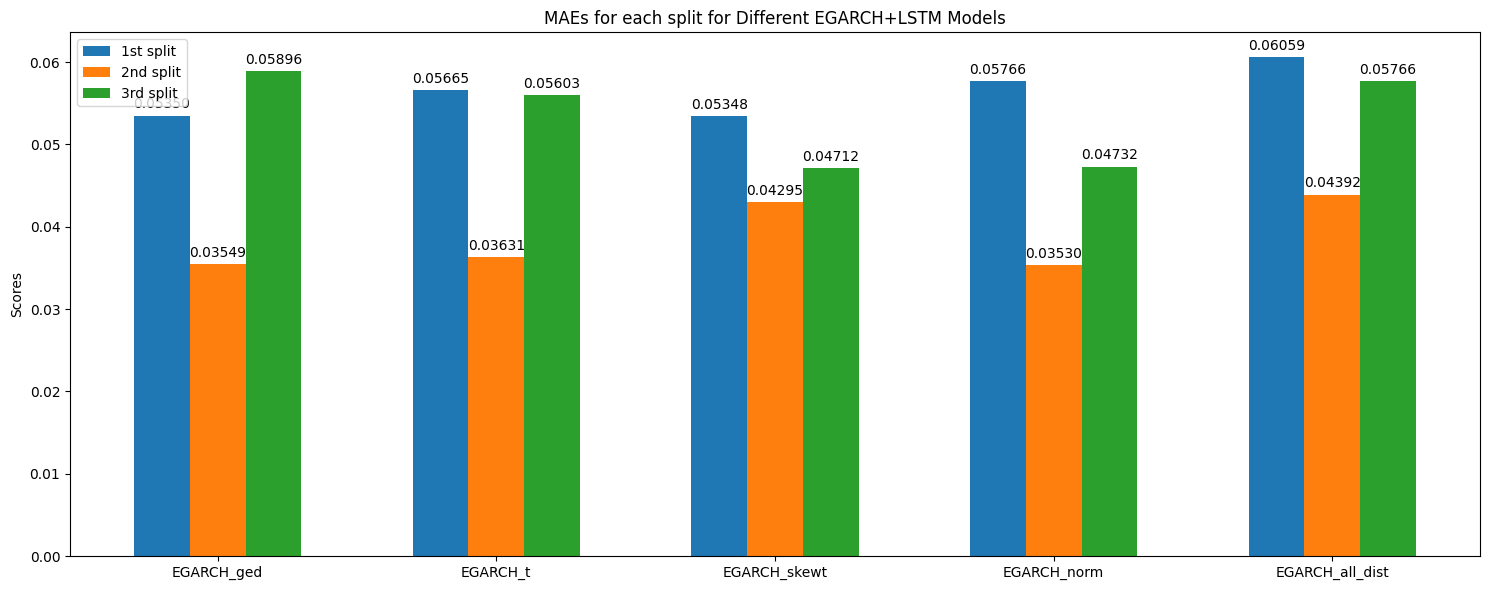

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['EGARCH_ged', 'EGARCH_t', 'EGARCH_skewt', 'EGARCH_norm', 'EGARCH_all_dist']
mse_scores = [
    np.array(EGARCH_ged_metric['test_MAE'])[0],
    np.array(EGARCH_t_metric['test_MAE'])[0],
    np.array(EGARCH_skewt_metric['test_MAE'])[0],
    np.array(EGARCH_norm_metric['test_MAE'])[0],
    np.array(EGARCH_all_dist_metric['test_MAE'])[0],
]
mae_scores = [
    np.array(EGARCH_ged_metric['test_MAE'])[1],
    np.array(EGARCH_t_metric['test_MAE'])[1],
    np.array(EGARCH_skewt_metric['test_MAE'])[1],
    np.array(EGARCH_norm_metric['test_MAE'])[1],
    np.array(EGARCH_all_dist_metric['test_MAE'])[1],
]
rmse_scores = [
    np.array(EGARCH_ged_metric['test_MAE'])[2],
    np.array(EGARCH_t_metric['test_MAE'])[2],
    np.array(EGARCH_skewt_metric['test_MAE'])[2],
    np.array(EGARCH_norm_metric['test_MAE'])[2],
    np.array(EGARCH_all_dist_metric['test_MAE'])[2],
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, mse_scores, width, label='1st split')
rects2 = ax.bar(x, mae_scores, width, label='2nd split')
rects3 = ax.bar(x + width, rmse_scores, width, label='3rd split')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MAEs for each split for Different EGARCH+LSTM Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("MAEs for each split for Different EGARCH+LSTM Models.jpg")
plt.show()


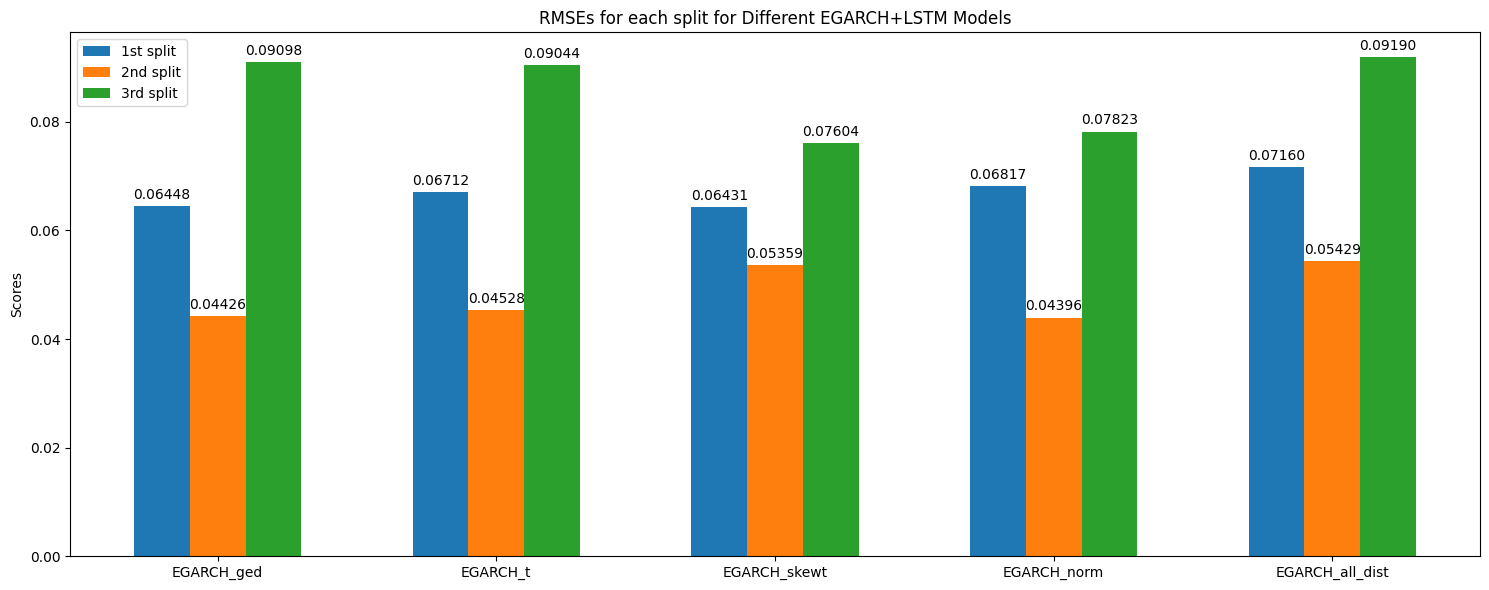

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


models = ['EGARCH_ged', 'EGARCH_t', 'EGARCH_skewt', 'EGARCH_norm', 'EGARCH_all_dist']
mse_scores = [
    np.array(EGARCH_ged_metric['test_RMSE'])[0],
    np.array(EGARCH_t_metric['test_RMSE'])[0],
    np.array(EGARCH_skewt_metric['test_RMSE'])[0],
    np.array(EGARCH_norm_metric['test_RMSE'])[0],
    np.array(EGARCH_all_dist_metric['test_RMSE'])[0],
]
mae_scores = [
    np.array(EGARCH_ged_metric['test_RMSE'])[1],
    np.array(EGARCH_t_metric['test_RMSE'])[1],
    np.array(EGARCH_skewt_metric['test_RMSE'])[1],
    np.array(EGARCH_norm_metric['test_RMSE'])[1],
    np.array(EGARCH_all_dist_metric['test_RMSE'])[1],
]
rmse_scores = [
    np.array(EGARCH_ged_metric['test_RMSE'])[2],
    np.array(EGARCH_t_metric['test_RMSE'])[2],
    np.array(EGARCH_skewt_metric['test_RMSE'])[2],
    np.array(EGARCH_norm_metric['test_RMSE'])[2],
    np.array(EGARCH_all_dist_metric['test_RMSE'])[2],
]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x - width, mse_scores, width, label='1st split')
rects2 = ax.bar(x, mae_scores, width, label='2nd split')
rects3 = ax.bar(x + width, rmse_scores, width, label='3rd split')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('RMSEs for each split for Different EGARCH+LSTM Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("RMSEs for each split for Different EGARCH+LSTM Models.jpg")
plt.show()
